In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# install necessary libraries
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.0+cu116
     |████████████████████████████████| 9.4 MB 8.4 MB/s 
     |████████████████████████████████| 4.6 MB 9.0 MB/s 
     |████████████████████████████████| 280 kB 6.9 MB/s 


In [4]:
# import required libraries and tools
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
import copy
from torch_geometric.utils import degree

from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

-------

# Load Datasets

This dataset contains a set of movie ratings from the MovieLens website, a movie recommendation service. This dataset was collected and maintained by University of Minnesota. There are 5 versions included: "25m", "latest-small", "100k", "1m", "20m". In this project, the movies data we used is the latest-small dataset. It has 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users.

dataset website: https://grouplens.org/datasets/movielens/

In [36]:
# download the dataset
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movie_path = './ml-latest-small/movies.csv'
rating_path = './ml-latest-small/ratings.csv'
links_path = './ml-latest-small/links.csv'
tags_path = './ml-latest-small/tags.csv'

Using existing file ml-latest-small.zip
Extracting ./ml-latest-small.zip


In [37]:
# load dataframe
movie_df = pd.read_csv(movie_path)
rating_df = pd.read_csv(rating_path)
links_df = pd.read_csv(links_path)
tags_df = pd.read_csv(tags_path)

In [38]:
# check how many rows and features of each dataframes
print('movie Data Summary: ', movie_df.shape)
print('rating Data Summary: ', rating_df.shape)
print('link Data Summary: ', links_df.shape)
print('tags Data Summary: ', tags_df.shape)

movie Data Summary:  (9742, 3)
rating Data Summary:  (100836, 4)
link Data Summary:  (9742, 3)
tags Data Summary:  (3683, 4)


In [39]:
movie_df.head(1)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [40]:
rating_df.head(1)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703


In [41]:
links_df.head(1)

,movieId,imdbId,tmdbId
0,1,114709,862.0


In [42]:
tags_df.head(1)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994


In [43]:
# check it if there is Null in the dataframe
movie_df.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [44]:
# check it if there is Null in the dataframe
rating_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [45]:
# check it if there is Null in the dataframe
links_df.isnull().sum()

movieId    0
imdbId     0
tmdbId     8
dtype: int64

In [46]:
tags_df.isnull().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

In [47]:
# check it if there is duplicated values in the dataframe
movie_df.duplicated().sum()

0

In [48]:
# check it if there is duplicated values in the dataframe
rating_df.duplicated().sum()

0

In [49]:
# check it if there is duplicated values in the dataframe
links_df.duplicated().sum()

0

In [50]:
tags_df.duplicated().sum()

0

--------------

# Popularity Based

Display the top movies with the highest rating: </br>
In this section, we are going to find out some of the top movies from the rating dataset.

In [51]:
movie_df.head(1)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [52]:
rating_df.head(1)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703


In [53]:
# merge two datasets together
movies_with_ratings = rating_df.merge(movie_df, on='movieId')
movies_with_ratings.head(1)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [54]:
# check how many rows and features
movies_with_ratings.shape

(100836, 6)

In [55]:
# groupby movies based on the title and sum up the rating of each movie, and reset the index
movies_with_ratings_df = movies_with_ratings.groupby('title').count()['rating'].reset_index()

In [56]:
movies_with_ratings_df.tail(1)

,title,rating
9718,À nous la liberté (Freedom for Us) (1931),1


In [57]:
# get the average of each movie
avg_movies_with_ratings_df = movies_with_ratings_df.groupby('title').mean()['rating'].reset_index()
avg_movies_with_ratings_df.tail(1)

,title,rating
9718,À nous la liberté (Freedom for Us) (1931),1.0


In [58]:
# merge two datasets
popular_movies_df = movies_with_ratings_df.merge(avg_movies_with_ratings_df, on="title")

In [59]:
popular_movies_df

,title,rating_x,rating_y
0,'71 (2014),1,1.0
1,'Hellboy': The Seeds of Creation (2004),1,1.0
2,'Round Midnight (1986),2,2.0
3,'Salem's Lot (2004),1,1.0
4,'Til There Was You (1997),2,2.0
...,...,...,...
9714,eXistenZ (1999),22,22.0
9715,xXx (2002),24,24.0
9716,xXx: State of the Union (2005),5,5.0
9717,¡Three Amigos! (1986),26,26.0


In [76]:
# make sure features'name are correct
popular_movies_df = popular_movies_df.rename(columns={"rating_x": "Movie_Rating", 
                                                    "rating_y": "Avg_Rating"}
                                          )

In [77]:
popular_movies_df.head(1)

,title,Movie_Rating,Avg_Rating
0,'71 (2014),1,1.0


sum up the rating scores 

In [95]:
# we set the thresold is ">=250", which means only consider those movies with high rating
most_popular_movies = popular_movies_df[popular_movies_df['Movie_Rating'] >= 250].sort_values('Avg_Rating', ascending=False)

In [96]:
most_popular_movies.head()

,title,Movie_Rating,Avg_Rating
3158,Forrest Gump (1994),329,329.0
7593,"Shawshank Redemption, The (1994)",317,317.0
6865,Pulp Fiction (1994),307,307.0
7680,"Silence of the Lambs, The (1991)",279,279.0
5512,"Matrix, The (1999)",278,278.0


In [97]:
# check how many top movies
most_popular_movies.shape

(6, 3)

---------

List most popular movies based on ratings

In [98]:
# just make sure we also show the 'genres' information of each movie
most_popular_movies_df = most_popular_movies.merge(movie_df, on = "title")

In [99]:
most_popular_movies_df = most_popular_movies_df.drop_duplicates('title')

In [100]:
most_popular_movies_df.shape

(6, 5)

In [101]:
most_popular_movies_df

,title,Movie_Rating,Avg_Rating,movieId,genres
0,Forrest Gump (1994),329,329.0,356,Comedy|Drama|Romance|War
1,"Shawshank Redemption, The (1994)",317,317.0,318,Crime|Drama
2,Pulp Fiction (1994),307,307.0,296,Comedy|Crime|Drama|Thriller
3,"Silence of the Lambs, The (1991)",279,279.0,593,Crime|Horror|Thriller
4,"Matrix, The (1999)",278,278.0,2571,Action|Sci-Fi|Thriller
5,Star Wars: Episode IV - A New Hope (1977),251,251.0,260,Action|Adventure|Sci-Fi


----------

# Collaborative Filtering Based

In this section, We will use the approach of collaborative filtering to build the system. Collaborative Filtering is try to search for those viewers/readers who have similar preference and provide suggestions based on user's ratings on similar movies. To find similar items, we will use a method to find the distance between data points, in this case, are the movie title, ratings, and other features.

In [102]:
# merge dataframes with same movie id
movies_with_ratings = rating_df.merge(movie_df, on='movieId')
movies_with_ratings.head(1)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [103]:
# check different ratings counts
movies_with_ratings.rating.value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [92]:
# check the dimension of the dataset
movies_with_ratings.shape

(100836, 6)

In [106]:
# select those users who have rated a lot movies
x = movies_with_ratings.groupby("userId").count()['rating'] > 150

In [107]:
# get the index
padhe_likhe_users = x[x].index

In [108]:
# put the index into dataframe, and see the result
filtered_rating = movies_with_ratings[movies_with_ratings['userId'].isin(padhe_likhe_users)]

In [110]:
filtered_rating.tail(1)

,userId,movieId,rating,timestamp,title,genres
100835,610,163981,3.5,1493850155,31 (2016),Horror


In [113]:
# collect the movies with highest sum (ratings)
y = filtered_rating.groupby('title').count()['rating'] >= 50

In [114]:
famous_movies = y[y].index

In [115]:
final_df = filtered_rating[filtered_rating['title'].isin(famous_movies)]

In [116]:
final_df

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
5,18,1,3.5,1455209816,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
6,19,1,4.0,965705637,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
7,21,1,3.5,1407618878,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
74478,594,1393,5.0,1109037039,Jerry Maguire (1996),Drama|Romance
74479,599,1393,4.0,1498499718,Jerry Maguire (1996),Drama|Romance
74480,600,1393,3.5,1237850723,Jerry Maguire (1996),Drama|Romance
74481,606,1393,3.5,1228164987,Jerry Maguire (1996),Drama|Romance


---------

Matrix factorization

In [117]:
# use pivot table to come up with the matrix
pt = final_df.pivot_table(index='title', columns='userId', values='rating')

In [118]:
pt

userId,1,4,6,7,18,19,20,21,28,33,...,596,597,599,600,603,605,606,607,608,610
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),NaN,NaN,NaN,4.0,4.0,3.0,NaN,NaN,3.0,NaN,...,4.0,NaN,5.0,4.0,5.0,NaN,5.0,NaN,3.0,4.5
300 (2007),NaN,NaN,NaN,NaN,3.5,NaN,NaN,3.5,4.5,NaN,...,NaN,NaN,3.0,NaN,NaN,3.0,NaN,NaN,5.0,4.0
"40-Year-Old Virgin, The (2005)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.5,1.5,NaN,NaN,NaN,NaN,NaN,4.5
Ace Ventura: Pet Detective (1994),NaN,NaN,3.0,NaN,2.5,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,2.5,3.0,NaN,NaN,NaN,NaN,3.5,3.0
Ace Ventura: When Nature Calls (1995),NaN,NaN,2.0,NaN,NaN,2.0,NaN,2.5,NaN,NaN,...,NaN,NaN,3.0,3.0,NaN,NaN,2.0,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Willy Wonka & the Chocolate Factory (1971),5.0,4.0,3.0,NaN,NaN,4.0,5.0,NaN,NaN,NaN,...,NaN,5.0,3.0,5.0,3.0,4.0,NaN,NaN,3.5,NaN
"Wizard of Oz, The (1939)",5.0,5.0,NaN,NaN,4.0,NaN,5.0,NaN,NaN,5.0,...,4.0,4.0,3.0,3.0,5.0,2.0,NaN,5.0,2.5,3.5
X-Men (2000),5.0,NaN,NaN,3.5,4.0,4.0,3.5,3.5,3.5,NaN,...,4.0,NaN,3.5,3.0,NaN,NaN,NaN,3.0,4.0,3.5


In [119]:
# replace Null to 0
pt.fillna(0, inplace=True)

In [120]:
pt

userId,1,4,6,7,18,19,20,21,28,33,...,596,597,599,600,603,605,606,607,608,610
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),0.0,0.0,0.0,4.0,4.0,3.0,0.0,0.0,3.0,0.0,...,4.0,0.0,5.0,4.0,5.0,0.0,5.0,0.0,3.0,4.5
300 (2007),0.0,0.0,0.0,0.0,3.5,0.0,0.0,3.5,4.5,0.0,...,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,5.0,4.0
"40-Year-Old Virgin, The (2005)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.5,1.5,0.0,0.0,0.0,0.0,0.0,4.5
Ace Ventura: Pet Detective (1994),0.0,0.0,3.0,0.0,2.5,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.5,3.0,0.0,0.0,0.0,0.0,3.5,3.0
Ace Ventura: When Nature Calls (1995),0.0,0.0,2.0,0.0,0.0,2.0,0.0,2.5,0.0,0.0,...,0.0,0.0,3.0,3.0,0.0,0.0,2.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Willy Wonka & the Chocolate Factory (1971),5.0,4.0,3.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,...,0.0,5.0,3.0,5.0,3.0,4.0,0.0,0.0,3.5,0.0
"Wizard of Oz, The (1939)",5.0,5.0,0.0,0.0,4.0,0.0,5.0,0.0,0.0,5.0,...,4.0,4.0,3.0,3.0,5.0,2.0,0.0,5.0,2.5,3.5
X-Men (2000),5.0,0.0,0.0,3.5,4.0,4.0,3.5,3.5,3.5,0.0,...,4.0,0.0,3.5,3.0,0.0,0.0,0.0,3.0,4.0,3.5


Users are columns; values are user's ratings. Each movie can be represented as a vector, we can draw this vector in space. And then, we can find similar vectors based on computing shorest/cloest distance between vectors.

Now, we can find the most similar items based on a item. To make that approach possible, we are gonning to use popular algorithm, cosine similarity.

In [121]:
from sklearn.metrics.pairwise import cosine_similarity

In [122]:
cosine_similarity(pt).shape

(260, 260)

In [123]:
# transform the original matrix to the matrix with similar score
similarity_scores = cosine_similarity(pt)

In [124]:
# check the first movie's similarity score with other moviess
similarity_scores[0]
# you notice the first value is 1, beacuse it's itself, so similarity score is 1

array([1.        , 0.42416575, 0.4068876 , 0.43266489, 0.32972766,
       0.58442345, 0.39426431, 0.67781873, 0.66937333, 0.37219509,
       0.48488137, 0.4211928 , 0.60110269, 0.48270999, 0.4442411 ,
       0.49439721, 0.43839592, 0.65886119, 0.48525552, 0.35373292,
       0.4410597 , 0.31700051, 0.45078586, 0.45283433, 0.42150133,
       0.42173719, 0.60655791, 0.45532409, 0.43612271, 0.56584056,
       0.47230829, 0.40593333, 0.42796009, 0.40723932, 0.46605101,
       0.46001416, 0.54407625, 0.50747167, 0.3516822 , 0.61064584,
       0.78936408, 0.53844017, 0.44447287, 0.45986009, 0.42052803,
       0.5573082 , 0.52318114, 0.30016761, 0.38092105, 0.4439322 ,
       0.5715579 , 0.37740957, 0.38824211, 0.42848858, 0.36796426,
       0.40979921, 0.4704643 , 0.37926959, 0.52980236, 0.47067463,
       0.63798943, 0.33790944, 0.58780563, 0.44429355, 0.51270285,
       0.50827566, 0.43725407, 0.43091835, 0.42761164, 0.63249791,
       0.41910579, 0.37832227, 0.42828292, 0.49273679, 0.69238

In [125]:
similarity_scores[0].shape

(260,)

In [127]:
# find row number based on movie title
np.where(pt.index=="X-Men (2000)")[0]

array([257])

In [128]:
np.where(pt.index == "X-Men (2000)")[0][0]

257

In [129]:
# again, check first movie's similarity score with other movies
# this time, we sorted the list
sorted(list(enumerate(similarity_scores[0])), key=lambda x:x[1], reverse = True)

[(0, 0.9999999999999998),
 (40, 0.7893640842455695),
 (74, 0.6923854934392611),
 (224, 0.6821936994703559),
 (225, 0.6807056618819258),
 (7, 0.6778187312597214),
 (8, 0.6693733303247105),
 (208, 0.668961028930751),
 (81, 0.6669145980483588),
 (183, 0.662437070510725),
 (184, 0.6608632474767404),
 (243, 0.6592771669722963),
 (17, 0.6588611914164083),
 (98, 0.6579998322758411),
 (97, 0.6489296548316276),
 (188, 0.6468631917753762),
 (124, 0.6461159555044798),
 (232, 0.6419864163114323),
 (226, 0.6404864051180905),
 (90, 0.6397305161549502),
 (60, 0.6379894341055097),
 (230, 0.6346872108508416),
 (69, 0.6324979070666693),
 (101, 0.6282333558121747),
 (95, 0.6271798587823836),
 (231, 0.6262854828484491),
 (195, 0.6209570291953297),
 (165, 0.6153836162960534),
 (131, 0.6143669447042707),
 (87, 0.6141415583489213),
 (155, 0.6115642130116576),
 (39, 0.6106458430873036),
 (182, 0.6089907888678422),
 (26, 0.6065579132397294),
 (12, 0.601102692430883),
 (107, 0.6004146576986784),
 (186, 0.597077

In [130]:
# def recommend(movie_name):
#   # index fetch
#   index = np.where(pt.index == movie_name)[0][0]
#   #distances = similarity_scores[index]
#   similar_items = sorted(list(enumerate(similarity_scores[index])), 
#                          key=lambda x:x[1], reverse = True)[1:6] # only get 5 most similar items
  
#   for i in similar_items:
#     print(pt.index[i[0]])

#   #return suggestions

In [131]:
movie_df.head(1)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [133]:
# input: get the title of the movie
# purpose: find the index of the movie, and compute cosine similarity
# output: get top 5 related movies
def recommend(movie_name):
    # index fetch
    index = np.where(pt.index==movie_name)[0][0]
    similar_items = sorted(list(enumerate(similarity_scores[index])),
                           key=lambda x:x[1],reverse=True)[1:5]
    
    data = []
    for i in similar_items:
        item = []
        temp_df = movie_df[movie_df['title'] == pt.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('title')['title'].values))
        item.extend(list(temp_df.drop_duplicates('genres')['genres'].values))
        
        data.append(item)
    
    return data

In [134]:
# test first movie with title, and see its most simliar movies 
recommend('X-Men (2000)')

[['X2: X-Men United (2003)', 'Action|Adventure|Sci-Fi|Thriller'],
 ['Spider-Man (2002)', 'Action|Adventure|Sci-Fi|Thriller'],
 ['Matrix, The (1999)', 'Action|Sci-Fi|Thriller'],
 ['Star Wars: Episode V - The Empire Strikes Back (1980)',
  'Action|Adventure|Sci-Fi']]

In [135]:
# check what movie title is at index 10
pt.index[10]

'Amadeus (1984)'

In [136]:
# test second movie, and see its most simliar movies 
recommend('Amadeus (1984)')

[['Apocalypse Now (1979)', 'Action|Drama|War'],
 ['Rear Window (1954)', 'Mystery|Thriller'],
 ['Silence of the Lambs, The (1991)', 'Crime|Horror|Thriller'],
 ['Godfather, The (1972)', 'Crime|Drama']]

We can save the model.

In [137]:
# import pickle
# pickle.dump(pt,open('pt.pkl','wb'))
# pickle.dump(movies,open('movies.pkl','wb'))
# pickle.dump(similarity_scores,open('similarity_scores.pkl','wb'))

----------

# Apply LightGCN 

According to the ratings，if a user rates a movie > 3.5，we will create an edge；otherwise，we will not create an edge.

We are going to use **Bayesian Personalized Ranking(BPR)**to compute the loss(y true - y pred)

In [138]:
# check rating df
rating_df = pd.read_csv(rating_path)

rating_df.tail()

,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


In [139]:
# check how many movies and users
print(len(rating_df['movieId'].unique()))
print(len(rating_df['userId'].unique()))

rating_df.describe()

9724
610


,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


Because those id are not sorted，it looks like 1，29，532....so, we need to make sure it sort in order

In [140]:
# perform encoding preprocessing to ensure that user_id and item_id are both 
# in the range of [0, unique_count] so it won't cause out of bound issue when indexing embeddings
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()

rating_df.userId = lbl_user.fit_transform(rating_df.userId.values)
rating_df.movieId = lbl_movie.fit_transform(rating_df.movieId.values)

In [141]:
print(rating_df.userId.max())
print(rating_df.movieId.max())
# now, it is sorted in order

609
9723


In [142]:
# check different ratings counts
# purpose：we gonna decide which threshold we gonna to use
rating_df.rating.value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

------------

In [143]:
# load edges between users and movies
# purpose：from COO, get rows and cols
def load_edge_csv(df, 
                  src_index_col, 
                  dst_index_col, 
                  link_index_col, 
                  rating_threshold=3):
    """Loads csv containing edges between users and items

    Args:
        src_index_col (str): column name of users
        dst_index_col (str): column name of items
        link_index_col (str): column name of user item interaction
        rating_threshold (int, optional): Threshold to determine positivity of edge. Defaults to 4.

    Returns:
        list of list: edge_index -- 2 by N matrix containing the node ids of N user-item edges
        N here is the number of interactions
    """
    
    edge_index = None
    
    # Constructing COO format edge_index from input rating events
    
    # get user_ids from rating events in the order of occurance
    src = [user_id for user_id in  df['userId']]    
    # get movie_id from rating events in the order of occurance
    dst = [(movie_id) for movie_id in df['movieId']]

    # apply rating threshold
    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold

    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])
    return edge_index

In [144]:
edge_index = load_edge_csv(
    rating_df,
    src_index_col='userId',
    dst_index_col='movieId',
    link_index_col='rating',
    rating_threshold=3.5, 
)

print(f"{len(edge_index)} x {len(edge_index[0])}")
# output: two arrays 

2 x 48580


In [145]:
# Convert to tensor
# We use LongTensor here because the .propagate() method in the model needs either LongTensor or SparseTensor
edge_index = torch.LongTensor(edge_index) 
print(edge_index)
print(edge_index.size())

tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9443, 9444, 9445]])
torch.Size([2, 48580])


In [146]:
# Note: this is the total num_users and num_movies before we apply the rating_threshold
# save user&movie into a global variables，we gonaa use them later
num_users = len(rating_df['userId'].unique())
num_movies = len(rating_df['movieId'].unique())

In [147]:
num_interactions = edge_index.shape[1]

# split the edges of the graph using a 80/10/10 train/validation/test split
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(all_indices, 
                                               test_size=0.2, 
                                               random_state=1)

val_indices, test_indices = train_test_split(test_indices, 
                                             test_size=0.5, 
                                             random_state=1)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [148]:
print(f"num_users {num_users}, num_movies {num_movies}, num_interactions {num_interactions}")
print(f"train_edge_index {train_edge_index}")
print((num_users + num_movies)) # total nodes 
print(torch.unique(train_edge_index[0]).size()) # length
print(torch.unique(train_edge_index[1]).size())

num_users 610, num_movies 9724, num_interactions 48580
train_edge_index tensor([[ 605,  110,  442,  ...,   65,  161,  427],
        [1110, 9619, 1283,  ..., 4640,  443,  827]])
10334
torch.Size([609])
torch.Size([5676])


-----

In [149]:
# helper function
# it convert regular connection matrix to COO
def convert_r_mat_edge_index_to_adj_mat_edge_index(input_edge_index):
    R = torch.zeros((num_users, num_movies))
    for i in range(len(input_edge_index[0])):
        row_idx = input_edge_index[0][i]
        col_idx = input_edge_index[1][i]
        R[row_idx][col_idx] = 1

    R_transpose = torch.transpose(R, 0, 1)
    adj_mat = torch.zeros((num_users + num_movies , num_users + num_movies))
    adj_mat[: num_users, num_users :] = R.clone()
    adj_mat[num_users :, : num_users] = R_transpose.clone()
    adj_mat_coo = adj_mat.to_sparse_coo()
    adj_mat_coo = adj_mat_coo.indices()
    return adj_mat_coo

In [150]:
# it does opposite of previous helper function
# it return back a user item interaction matrix
def convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index):
    sparse_input_edge_index = SparseTensor(row=input_edge_index[0], 
                                           col=input_edge_index[1], 
                                           sparse_sizes=((num_users + num_movies), num_users + num_movies))
    adj_mat = sparse_input_edge_index.to_dense()
    interact_mat = adj_mat[: num_users, num_users :]
    r_mat_edge_index = interact_mat.to_sparse_coo().indices()
    return r_mat_edge_index

In [151]:
# convert from r_mat (interaction matrix) edge index to adjescency matrix's edge index 
# so we can feed it to model
train_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(train_edge_index)
val_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(val_edge_index)
test_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(test_edge_index)

In [152]:
# check training、testing&val's dimension
print(train_edge_index)
print(train_edge_index.size())
print(val_edge_index)
print(val_edge_index.size())
print(test_edge_index)
print(test_edge_index.size())

tensor([[    0,     0,     0,  ..., 10326, 10327, 10333],
        [  610,   612,   653,  ...,   183,   183,   330]])
torch.Size([2, 77728])
tensor([[    0,     0,     0,  ..., 10226, 10236, 10240],
        [  615,   794,  2010,  ...,   317,   204,   413]])
torch.Size([2, 9716])
tensor([[    0,     0,     0,  ..., 10301, 10302, 10329],
        [  811,  1086,  1095,  ...,   585,   585,   183]])
torch.Size([2, 9716])


we are not gonna to use hyper-parameters tunning, the validation data is just for testing purpose.

-----------

select a batch from the dataset

In [153]:
# helper function for training and compute BPR loss
# since this is a self-supervised learning, we are relying on the graph structure itself and 
# we don't have label other than the graph structure so we need to the folloing function
# which random samples a mini-batch of positive and negative samples
def sample_mini_batch(batch_size, edge_index):
    """Randomly samples indices of a minibatch given an adjacency matrix

    Args:
        batch_size (int): minibatch size
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        tuple: user indices, positive item indices, negative item indices
    """
    # structured_negative_sampling is a pyG library
    # Samples a negative edge :obj:`(i,k)` for every positive edge
    # :obj:`(i,j)` in the graph given by :attr:`edge_index`, and returns it as a
    # tuple of the form :obj:`(i,j,k)`.
    #
    #         >>> edge_index = torch.as_tensor([[0, 0, 1, 2],
    #         ...                               [0, 1, 2, 3]])
    #         >>> structured_negative_sampling(edge_index)
    #         (tensor([0, 0, 1, 2]), tensor([0, 1, 2, 3]), tensor([2, 3, 0, 2]))
    edges = structured_negative_sampling(edge_index)
    
    # 3 x edge_index_len
    edges = torch.stack(edges, dim=0)
    
    # here is whhen we actually perform the batch sampe
    # Return a k sized list of population elements chosen with replacement.
    indices = random.choices([i for i in range(edges[0].shape[0])], k=batch_size)
    
    batch = edges[:, indices]
    
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

----------

# Implementing LightGCN

LightGCN Model as published in https://arxiv.org/abs/2002.02126

## Light Graph Convolution
Between each layer, LightGCN uses the following propagation rule for user and item embeddings.

\begin{equation}
e_u^{(k+1)} = \sum_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}} e_i^{(k)} \quad e_i^{(k+1)} = \sum_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}} e_u^{(k)}
\end{equation}

$N_u$: the set of all neighbors of user $u$ (items liked by $u$)

$N_i$: the set of all neighbors of item $i$ (users who liked $i$)

$e_u^{(k)}$ : k-th layer user embedding

$e_i^{(k)}$ : k-th layer item embedding



## Layer Combination and Model Prediction
The only trainable parameters of LightGCN are the 0-th layer embeddings $e_u^{(0)}$ and $e_i^{(0)}$ for each user and item. We combine the embeddings obtained at each layer of propagation to form the final embeddings for all user and item, $e_u$ and $e_i$ via the follwing equation.


\begin{equation}
e_u = \sum_{k = 0}^K \alpha_k e_u^{(k)} \quad e_i = \sum_{k = 0}^K \alpha_k e_i^{(k)}
\end{equation}

$\alpha_k$ : hyperparameter which weights the contribution of the k-th layer embedding to the final embedding

The model prediction is obtained by taking the inner product of the final user and item embeddings.

\begin{equation}
\hat{y}_{ui} = e_u^Te_i
\end{equation}

## Matrix Form
In our implementation, we utilize the matrix form of LightGCN. We perform multi-scale diffusion to obtain the final embedding, which sums embeddings diffused across multi-hop scales. 

\begin{equation}
E^{(K)} = \alpha_0 E^{(0)} + \alpha_1 \tilde{A}^1 E^{(0)} + \alpha_2 \tilde{A}^2 E^{(0)} + \cdot \cdot \cdot + \alpha_K \tilde{A}^K \tilde{A} E^{(0)}
\end{equation}

$E^{(0)} \in \mathcal{R}^{(M + N)} \times T$ : stacked initial item and user embeddings where $M$, $N$, and $T$ denote the number of users, number of items, and the dimension of each embedding respectively

$\tilde{A} = D^{-\frac{1}{2}}AD^{-\frac{1}{2}}$ : symmetrically normalized adjacency matrix


In [154]:
# defines LightGCN model 
class LightGCN(MessagePassing):

    def __init__(self, num_users, 
                 num_items, 
                 embedding_dim=64, # define the embding vector length for each node
                 K=3, 
                 add_self_loops=False):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K
        self.add_self_loops = add_self_loops

        # define user and item embedding for direct look up. 
        # embedding dimension: num_user/num_item x embedding_dim
        
        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        
        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0

        # "Fills the input Tensor with values drawn from the normal distribution"
        # according to LightGCN paper, this gives better performance
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: Tensor):
        """Forward propagation of LightGCN Model.

        Args:
            edge_index (SparseTensor): adjacency matrix

        Returns:
            tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """


        """
            compute \tilde{A}: symmetrically normalized adjacency matrix
            \tilde_A = D^(-1/2) * A * D^(-1/2)    according to LightGCN paper
        
            this is essentially a metrix operation way to get 1/ (sqrt(n_neighbors_i) * sqrt(n_neighbors_j))

        
            if your original edge_index look like
            tensor([[   0,    0,    0,  ...,  609,  609,  609],
                    [   0,    2,    5,  ..., 9444, 9445, 9485]])
                    
                    torch.Size([2, 99466])
                    
            then this will output: 
                (
                 tensor([[   0,    0,    0,  ...,  609,  609,  609],
                         [   0,    2,    5,  ..., 9444, 9445, 9485]]), 
                 tensor([0.0047, 0.0096, 0.0068,  ..., 0.0592, 0.0459, 0.1325])
                 )
                 
              where edge_index_norm[0] is just the original edge_index
              
              and edge_index_norm[1] is the symmetrically normalization term. 
              
            under the hood it's basically doing
                def compute_gcn_norm(edge_index, emb):
                    emb = emb.weight
                    from_, to_ = edge_index
                    deg = degree(to_, emb.size(0), dtype=emb.dtype)
                    deg_inv_sqrt = deg.pow(-0.5)
                    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
                    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

                    return norm
                 
                
        """
        edge_index_norm = gcn_norm(edge_index=edge_index, 
                                   add_self_loops=self.add_self_loops)

        # concat the user_emb and item_emb as the layer0 embing matrix
        # size will be (n_users + n_items) x emb_vector_len.   e.g: 10334 x 64
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0

        embs = [emb_0] # save the layer0 emb to the embs list
        
        # emb_k is the emb that we are actually going to push it through the graph layers
        # as described in lightGCN paper formula 7
        emb_k = emb_0 

        # push the embedding of all users and items through the Graph Model K times.
        # K here is the number of layers
        for i in range(self.K):
            emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)
            
            
        # this is doing the formula8 in LightGCN paper  
            
        # the stacked embs is a list of embedding matrix at each layer
        #    it's of shape n_nodes x (n_layers + 1) x emb_vector_len. 
        #        e.g: torch.Size([10334, 4, 64])
        embs = torch.stack(embs, dim=1)
        
        # From LightGCn paper: "In our experiments, we find that setting α_k uniformly as 1/(K + 1)
        #    leads to good performance in general."
        emb_final = torch.mean(embs, dim=1) # E^K


        # splits into e_u^K and e_i^K
        users_emb_final, items_emb_final = torch.split(emb_final, [self.num_users, self.num_items]) 

        # returns e_u^K, e_u^0, e_i^K, e_i^0
        # here using .weight to get the tensor weights from n.Embedding
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j, norm):
        # x_j is of shape:  edge_index_len x emb_vector_len
        #    e.g: torch.Size([77728, 64]
        #
        # x_j is basically the embedding of all the neighbors based on the src_list in coo edge index
        # 
        # elementwise multiply by the symmetrically norm. So it's essentiall what formula 7 in LightGCN
        # paper does but here we are using edge_index rather than Adj Matrix
        return norm.view(-1, 1) * x_j

layers = 3    
model = LightGCN(num_users=num_users, 
                 num_items=num_movies, 
                 K=layers)

# Loss Function



We utilize a Bayesian Personalized Ranking (BPR) loss, a pairwise objective which encourages the predictions of positive samples to be higher than negative samples for each user.

\begin{equation}
L_{BPR} = -\sum_{u = 1}^M \sum_{i \in N_u} \sum_{j \notin N_u} \ln{\sigma(\hat{y}_{ui} - \hat{y}_{uj})} + \lambda ||E^{(0)}||^2 
\end{equation}

$\hat{y}_{u}$: predicted score of a positive sample

$\hat{y}_{uj}$: predicted score of a negative sample

$\lambda$: hyperparameter which controls the L2 regularization strength

In [155]:
def bpr_loss(users_emb_final, 
             users_emb_0, 
             pos_items_emb_final, 
             pos_items_emb_0, 
             neg_items_emb_final, 
             neg_items_emb_0, 
             lambda_val):
    """Bayesian Personalized Ranking Loss as described in https://arxiv.org/abs/1205.2618

    Args:
        users_emb_final (torch.Tensor): e_u_k
        users_emb_0 (torch.Tensor): e_u_0
        pos_items_emb_final (torch.Tensor): positive e_i_k
        pos_items_emb_0 (torch.Tensor): positive e_i_0
        neg_items_emb_final (torch.Tensor): negative e_i_k
        neg_items_emb_0 (torch.Tensor): negative e_i_0
        lambda_val (float): lambda value for regularization loss term

    Returns:
        torch.Tensor: scalar bpr loss value
    """
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) # L2 loss

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples


    bpr_loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores))
    
    loss = bpr_loss + reg_loss
    
    return loss

# Evaluation Metrics

We evalaluate our model using the following metrics

\begin{equation}
\text{Recall} = \frac{TP}{TP + FP}
\end{equation}

\begin{equation}
\text{Precision} = \frac{TP}{TP + FN}
\end{equation}

Recall@k and Precision@k is just applying only the topK recommended items and then for the overall
Recall@k and Precision@k, it's just averaged by the number of users

**Dicounted Cumulative Gain (DCG)** at rank position p is defined as:

\begin{equation}
\text{DCG}_\text{p} = \sum_{i = 1}^p \frac{2^{rel_i} - 1}{\log_2{(i + 1)}}
\end{equation}

p: a particular rank position

$rel_i \in \{0, 1\}$ : graded relevance of the result at position $i$

**Idealised Dicounted Cumulative Gain (IDCG)**, namely the maximum possible DCG, at rank position $p$ is defined as:

\begin{equation}
\text{IDCG}_\text{p} = \sum_{i = 1}^{|REL_p|} \frac{2^{rel_i} - 1}{\log_2{(i + 1)}}
\end{equation}

$|REL_p|$ : list of items ordered by their relevance up to position p

**Normalized Dicounted Cumulative Gain (NDCG)** at rank position $p$ is defined as:

\begin{equation}
\text{nDCG}_\text{p} = \frac{\text{DCG}_p}{\text{nDCG}_p}
\end{equation}

Specifically, we use the metrics recall@K, precision@K, and NDCG@K. @K indicates that these metrics are computed on the top K recommendations.

In [156]:
def get_user_positive_items(edge_index):
    """
    Generates dictionary of positive items for each user

    Args:
        edge_index (torch.Tensor): 2 by N list of edges 

    Returns:
        dict: user -> list of positive items for each 
    """
    
    # key: user_id, val: item_id list
    user_pos_items = {}
    
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        
        if user not in user_pos_items:
            user_pos_items[user] = []
        
        user_pos_items[user].append(item)
        
    return user_pos_items

In [157]:
# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    """Computers recall @ k and precision @ k

    Args:
        groundTruth (list[list[long]]): list of lists of item_ids. Cntaining highly rated items of each user. 
                            In other words, this is the list of true_relevant_items for each user
                            
        r (list[list[boolean]]): list of lists indicating whether each top k item recommended to each user
                            is a top k ground truth (true relevant) item or not
                            
        k (int): determines the top k items to compute precision and recall on

    Returns:
        tuple: recall @ k, precision @ k
    """
    
    # number of correctly predicted items per user
    # -1 here means I want to sum at the inner most dimension
    num_correct_pred = torch.sum(r, dim=-1)  
    
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i]) for i in range(len(groundTruth))])
    
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [158]:
# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute ndcg on

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [159]:
# wrapper function to get evaluation metrics
def get_metrics(model, 
                input_edge_index, # adj_mat based edge index
                input_exclude_edge_indices, # adj_mat based exclude edge index
                k):
    """Computes the evaluation metrics: recall, precision, and ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        
        k (int): determines the top k items to compute metrics on

    Returns:
        tuple: recall @ k, precision @ k, ndcg @ k
    """
    # get the embedding tensor at layer 0 after training
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight
    

    # convert adj_mat based edge index to r_mat based edge index so we have have 
    # the first list being user_ids and second list being item_ids for the edge index 
    edge_index = convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index)

    # This is to exclude the edges we have seen before in our predicted interaction matrix (r_mat_rating)
    # E.g: for validation set, we want want to exclude all the edges in training set
    exclude_edge_indices = [convert_adj_mat_edge_index_to_r_mat_edge_index(exclude_edge_index) \
                                      for exclude_edge_index in input_exclude_edge_indices]

     

    # Generate predicted interaction matrix (r_mat_rating)    
    # (num_users x 64) dot_product (num_item x 64).T 
    r_mat_rating = torch.matmul(user_embedding, item_embedding.T)
    
    # shape: num_users x num_item
    rating = r_mat_rating
   
    for exclude_edge_index in exclude_edge_indices:
        # gets all the positive items for each user from the edge index
        # it's a dict: user -> positive item list
        user_pos_items = get_user_positive_items(exclude_edge_index)
        
        # get coordinates of all edges to exclude
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            # [user] * len(item) can give us [user1, user1, user1...] with len of len(item)
            # this makes easier to do the masking below
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)
   
        # set the excluded entry in the rat_mat_rating matrix to a very small number
        rating[exclude_users, exclude_items] = -(1 << 10) 

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(rating, k=k)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    # dict of user -> pos_item list
    test_user_pos_items = get_user_positive_items(edge_index)

    # convert test user pos items dictionary into a list of lists
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]


    # r here is "pred_relevant_items ∩ actually_relevant_items" list for each user
    r = []
    for user in users:
        user_true_relevant_item = test_user_pos_items[user.item()]
        # list of Booleans to store whether or not a given item in the top_K_items for a given user 
        # is also present in user_true_relevant_item.
        # this is later on used to compute n_rel_and_rec_k
        label = list(map(lambda x: x in user_true_relevant_item, top_K_items[user]))
        r.append(label)
        
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [160]:
# wrapper function to evaluate model
def evaluation(model, 
               edge_index, # adj_mat based edge index
               exclude_edge_indices,  # adj_mat based exclude edge index
               k, 
               lambda_val
              ):
    """Evaluates model loss and metrics including recall, precision, ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        sparse_edge_index (sparseTensor): sparse adjacency matrix for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on
        lambda_val (float): determines lambda for bpr loss

    Returns:
        tuple: bpr loss, recall @ k, precision @ k, ndcg @ k
    """
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(edge_index)
    
    r_mat_edge_index = convert_adj_mat_edge_index_to_r_mat_edge_index(edge_index)
    
    edges = structured_negative_sampling(r_mat_edge_index, contains_neg_self_loops=False)
    
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final, 
                    users_emb_0, 
                    pos_items_emb_final, 
                    pos_items_emb_0,
                    neg_items_emb_final, 
                    neg_items_emb_0, 
                    lambda_val).item()


    recall, precision, ndcg = get_metrics(model, 
                                          edge_index, 
                                          exclude_edge_indices, 
                                          k)

    return loss, recall, precision, ndcg

--------------

# Training

Your test set performance should be in line with the following (*K=20*):

*Recall@K: 0.13, Precision@K: 0.045, NDCG@K: 0.10*

In [165]:
# define contants
ITERATIONS = 10000
EPOCHS = 20
# ITERATIONS = 500
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-6
# LAMBDA = 1/2

In [166]:
# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")


model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

Using device cuda.


In [167]:
def get_embs_for_bpr(model, input_edge_index):
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(input_edge_index)
    

    edge_index_to_use = convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index)
    
    # mini batching for eval and calculate loss 
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, edge_index_to_use)
    
    # This is to push tensor to device so if we are using GPU
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)
    
 
    # we need layer0 embeddings and the final embeddings (computed from 0...K layer) for BPR loss computing
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]
   
    return users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0

In [168]:
# training loop
train_losses = []
val_losses = []
val_recall_at_ks = []

for iter in tqdm(range(ITERATIONS)):
    # forward propagation  
    users_emb_final, users_emb_0,  pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0 \
                = get_embs_for_bpr(model, train_edge_index)
    
    # loss computation
    train_loss = bpr_loss(users_emb_final, 
                          users_emb_0, 
                          pos_items_emb_final,
                          pos_items_emb_0, 
                          neg_items_emb_final, 
                          neg_items_emb_0, 
                          LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # validation set
    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        
        with torch.no_grad():
            val_loss, recall, precision, ndcg = evaluation(model, 
                                                           val_edge_index, 
                                                           [train_edge_index], 
                                                           K, 
                                                           LAMBDA
                                                          )

            print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")

            train_losses.append(train_loss.item())
            val_losses.append(val_loss)
            val_recall_at_ks.append(round(recall, 5))
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

[Iteration 0/10000] train_loss: -6.95226, val_loss: -5.05511, val_recall@20: 0.04966, val_precision@20: 0.01808, val_ndcg@20: 0.03064
[Iteration 200/10000] train_loss: -20.12618, val_loss: -14.73966, val_recall@20: 0.06966, val_precision@20: 0.02631, val_ndcg@20: 0.04664
[Iteration 400/10000] train_loss: -44.81311, val_loss: -31.84489, val_recall@20: 0.09009, val_precision@20: 0.03174, val_ndcg@20: 0.05954
[Iteration 600/10000] train_loss: -74.57561, val_loss: -55.90117, val_recall@20: 0.10356, val_precision@20: 0.03201, val_ndcg@20: 0.06847
[Iteration 800/10000] train_loss: -119.16861, val_loss: -83.98347, val_recall@20: 0.10245, val_precision@20: 0.03282, val_ndcg@20: 0.072
[Iteration 1000/10000] train_loss: -174.93268, val_loss: -118.14015, val_recall@20: 0.11052, val_precision@20: 0.03544, val_ndcg@20: 0.07582
[Iteration 1200/10000] train_loss: -210.5137, val_loss: -154.0896, val_recall@20: 0.11052, val_precision@20: 0.03535, val_ndcg@20: 0.08033
[Iteration 1400/10000] train_loss: 

# Visualization of Model's Performance

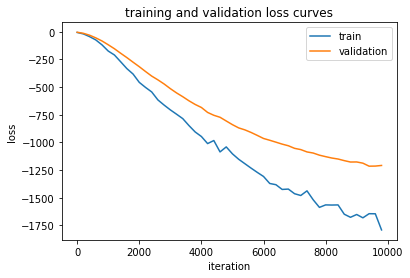

In [169]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

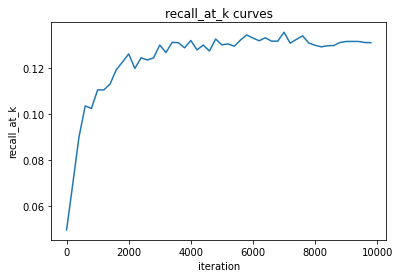

In [170]:
f2 = plt.figure()
plt.plot(iters, val_recall_at_ks, label='recall_at_k')
plt.xlabel('iteration')
plt.ylabel('recall_at_k')
plt.title('recall_at_k curves')
plt.show()

In [171]:
# evaluate on test set
model.eval()
test_edge_index = test_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(model, 
                                                               test_edge_index, 
                                                               [train_edge_index, val_edge_index], 
                                                               K, 
                                                               LAMBDA
                                                              )

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")

[test_loss: -1225.47192, test_recall@20: 0.12416, test_precision@20: 0.04339, test_ndcg@20: 0.09401
